# New itslive workflow

playing around trying to do it in a more succinct, organzied way, 11/15

defines `IndGlacier` class that contains:
1) rgi outline, 
2) itslive object, 
3) nasadem, 
4) ablation lines and 
5) centerlines

methods include: 
1) distance along flowline calculation

In [1]:
import xarray as xr 
import numpy as np
import pandas as pd
import geopandas as gpd 
import rioxarray as rio
import rioxarray.merge as merge
import itslivetools
import urllib.request
import json
import os
from osgeo import gdal
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from skimage.morphology import skeletonize
from itslivetools import *

## Utility functions

In [2]:
def get_bbox(input_xr, epsg):
    
    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

   
    crs = f"epsg:{epsg}"
    print(crs)
    
    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    #polygon = polygon.to_crs('epsg:4326')

    return polygon

## Reading in data

### ITS_LIVE (from s3, using `itslivetools`)

In [3]:
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url_catalog:
    itslive_catalog = json.loads(url_catalog.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

In [4]:
url = itslivetools.find_granule_by_point(itslive_catalog, [88.2511, 27.9676])

In [5]:
dc = itslivetools.read_in_s3(url[0])

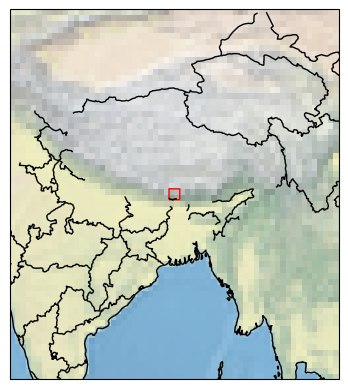

In [6]:
dc_bbox = itslivetools.get_bbox_single(dc)

### NASADEM (local)

In [7]:
dem_dir = '/home/emmamarshall/Desktop/data/nasadem/'
dem_ls = os.listdir(dem_dir)
dem_ls = [dem_ls[element] for element in range(len(dem_ls)) if '.nc' in dem_ls[element]]

In [8]:
dem_paths = [dem_dir + dem_ls[element] for element in range(len(dem_ls))]

In [9]:
qgis_dem = xr.open_dataset('/home/emmamarshall/Desktop/data/nasadem/merged_dem_qgis.nc').squeeze()

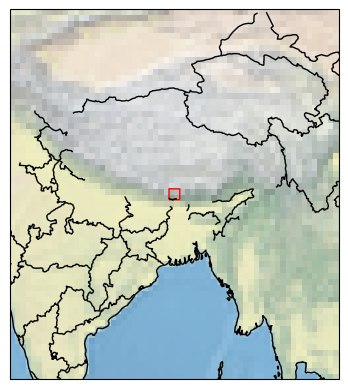

In [10]:
da_bbox = get_bbox_single(dc)
da_bbox = da_bbox.to_crs('EPSG:32645')

### RGI outlines (uploaded to github repo)

In [11]:
rgi = gpd.read_file('https://github.com/e-marshall/itslive/raw/master/rgi15_southasiaeast.geojson')
rgi.head(3)
rgi_prj = rgi.to_crs('epsg:32645')

rgi_sub = gpd.sjoin(rgi_prj, da_bbox, how='inner')

In [12]:
rgi_sub

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
2696,RGI60-15.02697,G088184E27891N,20001108,-9999999,88.183836,27.890705,15,2,0.526,5512,...,1239,0,0,0,0,9,9,None,"POLYGON ((616219.593 3085917.382, 616223.232 3...",0
2697,RGI60-15.02698,G088155E27898N,20001108,-9999999,88.155126,27.898019,15,2,11.710,5202,...,7398,0,0,0,0,9,9,None,"POLYGON ((617373.178 3088393.887, 617410.220 3...",0
2698,RGI60-15.02699,G088130E27874N,20001108,-9999999,88.129556,27.873683,15,2,3.011,6798,...,2134,0,0,0,0,9,9,None,"POLYGON ((612141.972 3083076.812, 612110.222 3...",0
2699,RGI60-15.02700,G088184E27900N,20001108,-9999999,88.183625,27.899983,15,2,0.313,5392,...,970,0,0,0,0,9,9,None,"POLYGON ((616267.486 3086560.269, 616241.741 3...",0
2700,RGI60-15.02701,G088226E27869N,20001108,-9999999,88.226304,27.868729,15,2,0.081,5721,...,261,0,0,0,0,9,9,None,"POLYGON ((620545.118 3083321.350, 620549.409 3...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10973,RGI60-15.10974,G088868E27981N,20100128,-9999999,88.868000,27.981000,15,2,0.385,5961,...,1124,0,0,0,0,9,9,CN5O252B0006,"POLYGON ((683235.004 3096049.669, 683246.190 3...",0
10974,RGI60-15.10975,G088871E27977N,20100128,-9999999,88.871000,27.977000,15,2,0.355,5870,...,1275,0,0,0,0,9,9,CN5O252B0005,"POLYGON ((683858.052 3096314.258, 683855.273 3...",0
10975,RGI60-15.10976,G088880E27945N,20100128,-9999999,88.880000,27.945000,15,2,1.316,5627,...,2317,0,0,0,0,9,9,CN5O252B0003 Baohongli Glacier,"POLYGON ((684286.345 3092298.524, 684312.155 3...",0
10976,RGI60-15.10977,G088892E27944N,20100128,-9999999,88.892000,27.944000,15,2,0.985,5705,...,1350,0,0,0,0,9,9,CN5O252B0002,"POLYGON ((685455.327 3092087.941, 685454.942 3...",0


In [13]:
#list of glaciers w/ term type specified
term_types = pd.read_csv('hma_glacier_term_types_1021.csv')

### Centerline data (local)

from this paper (link)

In [14]:
sa_east_ablationlines = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_ablationlines/15_rgi60_SouthAsiaEast_Ablationlines.shp')
sa_east_centerlines = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_centerlines/15_rgi60_SouthAsiaEast_final_lines.shp')
sa_east_lowestPoints = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_lowestPoints/15_rgi60_SouthAsiaEast_minimumpoints.shp')

In [15]:
sa_east_centerlines.head()

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry
0,G102044E29941N,1,1278.0,1278.0,5224,556.0,722.0,"LINESTRING (1064475.427 376944.037, 1064474.88..."
1,G102042E29987N,1,1416.0,1217.0,5159,534.0,882.0,"MULTILINESTRING ((1063655.823 381517.030, 1063..."
2,G102041E29997N,1,890.0,890.0,5103,488.0,402.0,"LINESTRING (1063609.564 382931.401, 1063610.50..."
3,G102050E29962N,1,2406.0,2406.0,4978,961.0,1444.0,"LINESTRING (1065455.354 379766.938, 1065447.69..."
4,G102044E30025N,1,1347.0,1149.0,5008,799.0,548.0,"MULTILINESTRING ((1063293.156 385717.107, 1063..."


In [16]:
a = rgi_sub.loc[rgi_sub['GLIMSId'] == 'G088251E27968N']['GLIMSId']
a = a.values
a[0]

'G088251E27968N'

In [17]:
#sa_east_centerlines.loc[sa_east_centerlines['GLIMS_ID'] == 'G088251E27968N']
sa_east_centerlines.loc[sa_east_centerlines['GLIMS_ID'] == a[0]]

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry
10347,G088251E27968N,2,6242.0,5895.0,5992,1836.0,4406.0,"MULTILINESTRING ((-269440.674 108484.044, -269..."


## Starting setup of ind glacier object

### some object setup

In [18]:
class IndGlacier:
    
    def __init__(self, rgi_id, dem, itslive, centerLine=None, ablationLine = None, lowestPoint = None):
        
        self.rgi_id = rgi_id
        self.dem = dem
        self.itslive = itslive
        self.centerLine = centerLine
        self.ablationLine = ablationLine
        self.lowestPoint = lowestPoint
    
    def calc_flowline_distance(self):
        '''function to calculate distance from glacier terminus along flowline. should ultimately be a method of the Glacier class.
    takes an endpoint object and a ablation line vector. should return a 1D array with distance from terminus (or maybe a geodataframe with each point and dist as an attr??
    NO - doesn't take endpont, only ablation line because the end point does not always lie along the ablation line -- not sure the best way to handle this'''

   
    
        dl = np.zeros(len(list(self.ablationLine['geometry'].iloc[0].coords))) # make an empty array the list of the ablation line vector

        #dl = np.zeros(5)

        coords = list(self.ablationLine['geometry'].iloc[0].coords)

        coords_X = [coords[point][0] for point in range(len(coords))]
        coords_Y = [coords[point][1] for point in range(len(coords))]

        dl[1:] = np.sqrt(np.diff(coords_X)**2 + np.diff(coords_Y)**2)

        dist_profile = pd.DataFrame({'x_coords': coords_X,
                                 'y_coords': coords_Y,
                                 'distance': np.cumsum(dl)})
    
        geometry = gpd.points_from_xy(dist_profile['x_coords'], dist_profile['y_coords'])

        gdf = gpd.GeoDataFrame(
            dist_profile, geometry= geometry)

        return gdf

    
    

### object prep 
a few steps here. need to: 
1) write orig CRS of dem (4326) 
2) write crs of itslive object (local utm) 
3) reproject dem to local utm (32645 here) 
4) clip DEM and itslive objects by the single glacier gpdf 
5) downsample dem to match resolution of itslive

In [19]:
#steps to do outside of function on entire data object (for dem and itslive): write crs
qgis_dem = qgis_dem.rio.write_crs('EPSG:4326')
dc = dc.rio.write_crs('EPSG:32645')
#reproject dem to local utm
dem_prj = qgis_dem.rio.reproject('EPSG:32645')

In [20]:
def ind_glacier_data_prep(rgi_id, rgi_full, itslive_dc, dem_obj, centerlines, ablationlines, lowestpoints, utm_code):
    '''function to prepare data to create an object of the `IndGlacier` class for a single glacier.
    Pass in RGI ID of glacier of interest as well as full data objects of RGI gpdf, itslive datacube, 
    nasadem and the u tm code fo the glacier.I feel like at scale this is probably a really inefficient way to build objects'''
    
    #clip rgi to glacier
    single_rgi = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    #extract glims id - will use to extract centerlines
    glims_id = single_rgi['GLIMSId'].values
    
    #clip dem and itslive
    dem_clip = dem_obj.rio.clip(single_rgi.geometry, dem_obj.rio.crs).squeeze()
    itslive_clip = itslive_dc.rio.clip(single_rgi.geometry, itslive_dc.rio.crs)
    dem_clip_downsamp = dem_clip.interp_like(itslive_clip, method = 'nearest')
    
    #centerline objects
    centerline = centerlines.loc[centerlines['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    ablationline = ablationlines.loc[ablationlines['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    lowestpoint = lowestpoints.loc[lowestpoints['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    
    #centerline = centerline.to_crs(utm_code)
    #ablationline = ablationline.to_crs(utm_code)
    #lowestpoint = lowestpoints.to_crs(
    
    #creat object of IndGlacier class
    glacier = IndGlacier(rgi_id, dem_clip_downsamp, itslive_clip, centerline, ablationline, lowestpoint)
    
    return glacier

In [21]:
g10463 = ind_glacier_data_prep('RGI60-15.10463', rgi_sub, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

In [22]:
g10463.centerLine.crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
#fig, ax = plt.subplots()

#g10463.itslive.v.mean(dim='mid_date').plot(ax=ax)
#g10463.centerLine.plot(ax=ax)
#g10463.ablationLine.plot(ax=ax, color= 'red')
#g10463.lowestPoint.plot(ax=ax, color = 'orange');

In [24]:
flowline = g10463.calc_flowline_distance()

In [28]:
flowline

,x_coords,y_coords,distance,geometry
0,623621.609203,3.093597e+06,0.000000,POINT (623621.609 3093597.393)
1,623622.770204,3.093609e+06,11.574409,POINT (623622.770 3093608.909)
2,623622.347088,3.093609e+06,12.144376,POINT (623622.347 3093609.291)
3,623621.214544,3.093610e+06,13.631725,POINT (623621.215 3093610.255)
4,623619.382615,3.093612e+06,15.994424,POINT (623619.383 3093611.748)
...,...,...,...,...
216,622143.865712,3.097527e+06,4399.137550,POINT (622143.866 3097526.744)
217,622141.968944,3.097527e+06,4401.104123,POINT (622141.969 3097527.263)
218,622140.127646,3.097528e+06,4402.999628,POINT (622140.128 3097527.714)
219,622137.891305,3.097528e+06,4405.290336,POINT (622137.891 3097528.210)


<AxesSubplot:>

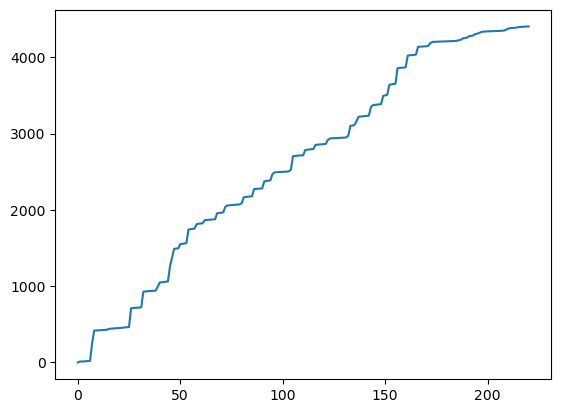

In [26]:
flowline['distance'].plot()

### Interpolating velocity data along flowline

Now we have a dataframe with flowline coordinates and corresonding distances along flowline. Need to extract the itslive velocity data corresponding to these points

In [27]:
flowline_x = flowline['x_coords']
flowline_y = flowline['y_coords']

In [30]:
interp = g10463.itslive.interp(x = flowline_x, y = flowline_y)

In [ ]:
interp.to_zarr('g10463_flowline.zarr')

In [29]:
#interp_tmean = interp.v.mean(dim='mid_date')

In [ ]:
#flowline_mean_v_df = interp_tmean.to_dataframe()

In [31]:
interp = interp.chunk({'mid_date': 'auto'})

In [ ]:
interp.to_zarr('g10463_flowline.zarr')

In [32]:
#interp_v

<xarray.DataArray 'v' (mid_date: 25372, y: 221, x: 221)>
dask.array<rechunk-merge, shape=(25372, 221, 221), dtype=float32, chunksize=(687, 221, 221), chunktype=numpy.ndarray>
Coordinates:
    mapping   int64 0
  * mid_date  (mid_date) datetime64[ns] 2022-01-04T04:51:04.527088128 ... 201...
  * x         (x) float64 6.236e+05 6.236e+05 6.236e+05 ... 6.221e+05 6.221e+05
  * y         (y) float64 3.094e+06 3.094e+06 3.094e+06 ... 3.098e+06 3.098e+06
Attributes:
    description:    velocity magnitude
    grid_mapping:   mapping
    standard_name:  velocity
    units:          m/y

Discussion of `xr.to_dataframe()` with dask arrays [here](https://stackoverflow.com/questions/40475884/how-to-convert-an-xarray-dataset-to-pandas-dataframes-inside-a-dask-dataframe). Could help with the issues i'm having?

In [ ]:
#v_flowline_df = interp.v.mean(dim='mid_date').to_dataframe()

In [79]:
coord1 = list(flowline.iloc[0]['geometry'].coords)[0]
coord_mid = list(flowline.iloc[-50]['geometry'].coords)[0]
coord_end = list(flowline.iloc[-30]['geometry'].coords)[0]

Text(0.5, 0.98, 'velocity at individual points along flowline over time')

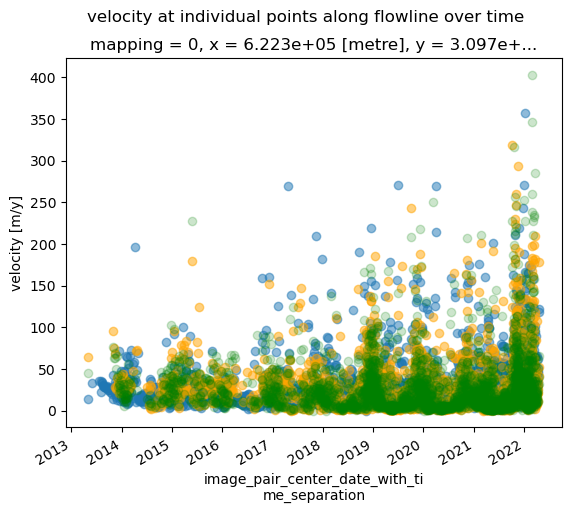

In [81]:
#g10463.itslive.sel(x = coord[1], y = coord[0] , method = 'nearest').v.plot()
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
g10463.itslive.v.interp(x = coord1[0], y = coord1[1]).plot(marker='o', linestyle='None', ax=axs[0], alpha = 0.5)
g10463.itslive.v.interp(x = coord_mid[0], y = coord_mid[1]).plot(marker='o', linestyle='None', ax=axs[0], color='orange', alpha = 0.5)
g10463.itslive.v.interp(x = coord_end[0], y = coord_end[1]).plot(marker= 'o', linestyle='None', ax=axs[0], color = 'green', alpha = 0.2)
plt.suptitle('velocity at individual points along flowline over time')

In [461]:
g10463.ablationLine

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry
10347,G088251E27968N,2,6242.0,5895.0,5992,1836.0,4406.0,"LINESTRING (623621.609 3093597.393, 623622.770..."


<AxesSubplot:>

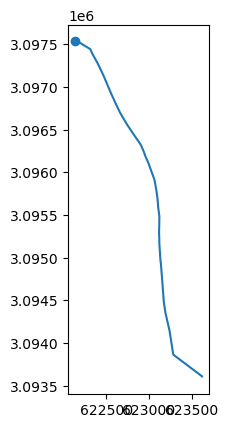

In [202]:
fig, ax = plt.subplots()
g10463.ablationLine.plot(ax=ax)
g10463.lowestPoint.plot(ax=ax)

In [1]:
def calc_flowline_distance(obj):
    '''function to calculate distance from glacier terminus along flowline. should ultimately be a method of the Glacier class.
    takes an endpoint object and a ablation line vector. should return a 1D array with distance from terminus (or maybe a geodataframe with each point and dist as an attr??
    NO - doesn't take endpont, only ablation line because the end point does not always lie along the ablation line -- not sure the best way to handle this'''

   
    
    dl = np.zeros(len(list(obj.ablationLine['geometry'].iloc[0].coords))) # make an empty array the list of the ablation line vector
    
    #dl = np.zeros(5)
    
    sample_coords = list(obj.ablationLine['geometry'].iloc[0].coords)
    
    sample_coords_X = [sample_coords[point][0] for point in range(len(sample_coords))]
    sample_coords_Y = [sample_coords[point][1] for point in range(len(sample_coords))]

    dl[1:] = np.sqrt(np.diff(sample_coords_X)**2 + np.diff(sample_coords_Y)**2)
    
    dist_profile = pd.DataFrame({'x_coords': sample_coords_X,
                                 'y_coords': sample_coords_Y,
                                 'distance': np.cumsum(dl)})
    
    geometry = gpd.points_from_xy(dist_profile['x_coords'], dist_profile['y_coords'])
    
    gdf = gpd.GeoDataFrame(
        dist_profile['distance'], geometry= geometry)
                    
    #return np.cumsum(dl)
    return gdf
    


In [2]:
flowline = calc_flowline_distance(g10463)

NameError: name 'g10463' is not defined